# Imports and downloads

In [ ]:
!pip install NRCLex
!pip install torch
!pip install stanza

     |████████████████████████████████| 396 kB 5.1 MB/s 
  Created wheel for NRCLex: filename=NRCLex-3.0.0-py3-none-any.whl size=43329 sha256=63094a1e36dc09e5b55f92a108b1485548de26e4701bc083f93e4d05b1bc1e27
  Stored in directory: /root/.cache/pip/wheels/af/2c/9c/dfa19d1b65326c520b32850a9311f6d4eda679ac04dba26081
Successfully built NRCLex
     |████████████████████████████████| 574 kB 4.8 MB/s 
     |████████████████████████████████| 175 kB 8.2 MB/s 
     |████████████████████████████████| 4.0 MB 19.4 MB/s 
     |████████████████████████████████| 596 kB 12.9 MB/s 
     |████████████████████████████████| 77 kB 6.5 MB/s 
     |████████████████████████████████| 6.6 MB 43.3 MB/s 
     |████████████████████████████████| 895 kB 46.1 MB/s 
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171046 sha256=345752ad3caf09a91719ba54a428f564e2fc1937ec3bf41cb4a5ee500439fd8c
  Stored in directory: /root/.cache/pip/wheels/8a/4e/b6/57b01db010d17ef6ea9b40300af725ef3e210cb1acfb7ac8b6
Su

In [ ]:
import stanza
stanza.download('en')
import nltk
nltk.download('punkt')
from bs4 import BeautifulSoup
from nrclex import NRCLex
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score

2022-04-24 12:15:54 INFO: Downloading default packages for language: en (English)...


2022-04-24 12:16:14 INFO: Finished downloading models and saved to /root/stanza_resources.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Converting Data to JSON

In [ ]:
def get_character_dictionary_from_html(filename, name_position, dialogue_position, scenario_position):
  """
  This function takes the name of the file, the starting position of the name, dialogue,
  and scenario. Then, returns the dictionary.

    Parameters:
      filename: string: The path of the file to read
      name_position: float: The starting value of left pixel for name of character
      dialogue_position: float: The starting value of left pixel for dialogues
      scenario_position: float: The starting value of left pixel for scenarios

    Returns:
      character_dialogues: dict: A dictionary with every character's dialogues,
                               : The sample format is "Name": list of dialogues
      scenarios: dict: A list of scenarios, with the key "scenarios". It is kept
                      as a dict because we can further classify it into different
                      kinds of scenarios if we want
  """
  with open(filename) as fp:
      soup = BeautifulSoup(fp, "html.parser")

  everything = soup.find_all('div')
  character_dialogues = {}
  character = ""
  scenarios = {'scenarios': []} 
  dialogue = "" 
  dialogue_ready = False
  for div in everything:
    try:
      if float(div['style'].split(';')[1].split(':')[1].split('px')[0]) >= name_position-5 \
       and float(div['style'].split(';')[1].split(':')[1].split('px')[0]) <= name_position+5:
        if dialogue_ready:  # For the first dialogue
          if not character_dialogues.get(character):
            character_dialogues[character] = []
          character_dialogues[character].append(dialogue)
          dialogue = ""
        character = div.text  # Character updated
      if float(div['style'].split(';')[1].split(':')[1].split('px')[0]) >= dialogue_position-5 \
       and float(div['style'].split(';')[1].split(':')[1].split('px')[0]) <= dialogue_position+5:
        dialogue = dialogue + " " + div.text
        dialogue_ready = True
      if float(div['style'].split(';')[1].split(':')[1].split('px')[0]) >= scenario_position-5 \
       and float(div['style'].split(';')[1].split(':')[1].split('px')[0]) <= scenario_position+5:
        scenarios['scenarios'].append(div.text)
    except:
      pass
    
  if not character_dialogues.get(character):
    character_dialogues[character] = []
  character_dialogues[character].append(dialogue)
  dialogue = ""

  return character_dialogues, scenarios

In [ ]:
def get_character_dictionary_from_text(filename, name_position, dialogue_position, scenario_position):
  """
  This function converts a text file inot a character dictionary.

    Parameters:
      filename: string: The path of the file to read
      name_position: int: Number of spaces before the name
      dialogue_position: int: Number of spaces before the dialogues
      scenario_position: int: Number of spaces before the scenarios

    Returns:
      character_dialogues: dict: A dictionary with every character's dialogues,
                               : The sample format is "Name": list of dialogues
      scenarios: dict: A list of scenarios, with the key "scenarios". It is kept
                      as a dict because we can further classify it into different
                      kinds of scenarios if we want
  """
  # Filtering the empty lines
  lines = list(filter(lambda x: x!='', open(filename).read().split('\n')))
  character_dialogues = {}
  scenarios = {'scenarios': []} 
  dialogue = "" 
  dialogue_ready = False
  for line in lines:  # for every line
    line_arr = line.split(":") 
    if len(line_arr) == 1:
      scenarios['scenarios'].append(line_arr[0])
    elif len(line_arr) == 2:
      character = line_arr[0]
      dialogue = line_arr[1]
      # If some random line is classified as a dialogue, skip it; 
      if len(character) >= 30:
        continue
      if not character_dialogues.get(character):
          character_dialogues[character] = []
      character_dialogues[character].append(dialogue)
  return character_dialogues, scenarios

In [ ]:
"""
Should we write like a driver function?
"""
character_dialogues, scenarios = get_character_dictionary_from_html("the-shawshank-redemption-1994.html", 252, 180, 108 )
import json
with open('the-shawshank-redemption-1994.json', 'w') as fp:
    json.dump(character_dialogues, fp)

with open('the-shawshank-redemption-1994_scenario.json', 'w') as fp:
    json.dump(scenarios, fp)

# Pre processing and finding gender

In [ ]:
def process(name):
  """
  Takes a name and remove anything written in brackets
  """
  final_name = ''
  names = name.split(' ')
  for n in names:
    if len(n)==0:
      continue
    if n[0] == '(':
      break
    final_name += n + ' '
  return final_name.strip()

names_of_characters = list(set([(process(i), len(character_dialogues[i])) for i in character_dialogues.keys()]))
names_of_characters = list(set([ i for i, j in names_of_characters if j>= 10]))
names_of_characters

['',
 'RED',
 'BROOKS',
 'NORTON',
 'TOMMY',
 'FLOYD',
 'D.A.',
 'HEYWOOD',
 'ANDY',
 'HADLEY']

In [ ]:
import json
from urllib.request import urlopen
myKey = 'ejwLB6735DjwrCJvrnnjvMBtoAKrAU7Jku7J'
name_gender = {}
for name in names_of_characters:
  if name == '':
    continue
  if name.find(' ') != -1:
    continue
  url = "https://gender-api.com/get?key=" + myKey + "&name=" + name
  response = urlopen(url)
  decoded = response.read().decode('utf-8')
  data = json.loads(decoded)
  print( name + ": " + data["gender"]); #Gender: male
  name_gender[name] = data["gender"]

RED: male
BROOKS: male
NORTON: male
TOMMY: male
FLOYD: male
D.A.: male
HEYWOOD: male
ANDY: male
HADLEY: female


In [ ]:
name_gender['RED'] = 'male'
name_gender['BROOKS'] = 'male'
name_gender['NORTON'] = 'male'
name_gender['TOMMY'] = 'male'
name_gender['FLOYD'] = 'male'
name_gender['D.A'] = 'male'
name_gender['HEYWOOD'] = 'male'
name_gender['ANDY'] = 'male'
name_gender['HADLEY'] = 'male'




In [ ]:
df = pd.Series(character_dialogues, name='text').rename_axis('character').explode().reset_index()
df.character = df.character.apply(process)
df['gender'] = df.character.apply(lambda x: name_gender.get(x, "unknown"))

In [ ]:
df = df[df['gender'] != 'unknown'].reset_index(drop=True)

In [ ]:
df.to_csv('the-shawshank-redemption-1994.csv', index=False)

# Sentiment Analysis

## Stanza

In [ ]:
def get_sentiments(dialogues):
  """
  Takes a list of dialogues spoken by a character and classify it into
  positive, negative, or neutral sentiment

    Parameters:
      dialogues: list: List of dialogues to be setimentized

    Returns:
      sentiment_count: Count of each sentiment in the dialogues.
  """
  emotions = ['Negative', 'Neutral', 'Positive']
  nlp = stanza.Pipeline(lang='en', processors='tokenize,sentiment')
  doc = nlp(". ".join(dialogues))
  sentiment = [i.sentiment for i in doc.sentences]
  sentiment_count = np.unique(sentiment, return_counts=True)
  
  # Getting the right name for the emotion instead of numeric number
  sentiment_count = dict(zip(map(lambda x: emotions[x], sentiment_count[0]),
                             sentiment_count[1]))
  return sentiment_count

In [ ]:
"""
Main script that reads the databases, run stanza on them, and save the final dataframe
"""
movies = ['marvel', 'hp', 'PP', 'horror']  # A list of movies data bases we are going to work with
data_frames = {}
character_sentiments = {}
genders = {}  # A dict of dict

# Reading the files for all the movies
for movie in movies:
  data_frames[movie] = pd.read_csv(movie+'_db.csv').drop('Unnamed: 0', axis=1)

# Running Stanza on the characters
for movie in movies:
  df = data_frames[movie]  # for convinience
  for character in df.character.unique():
    if not character_sentiments.get(movie):
      character_sentiments[movie] = {}
      genders[movie] = dict(data_frames[movie].groupby('character')['types'].agg('unique').apply(lambda x: x[0]).fillna('NA'))
    character_sentiments[movie][character] = get_sentiments(df[df.character==character]['text'])

2022-03-28 18:12:58 INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| sentiment | sstplus  |

2022-03-28 18:12:58 INFO: Use device: cpu
2022-03-28 18:12:58 INFO: Loading: tokenize
2022-03-28 18:12:58 INFO: Loading: sentiment
2022-03-28 18:12:59 INFO: Done loading processors!
2022-03-28 18:13:02 INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| sentiment | sstplus  |

2022-03-28 18:13:02 INFO: Use device: cpu
2022-03-28 18:13:02 INFO: Loading: tokenize
2022-03-28 18:13:02 INFO: Loading: sentiment
2022-03-28 18:13:03 INFO: Done loading processors!
2022-03-28 18:13:05 INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| sentiment | sstplus  |

2022-03-28 18:13:05 INFO: Use device: cpu
2022-03-28 18:13:05 INFO: Loading: tokenize
2022-03-28 18:13:05 IN

## Visualizations

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


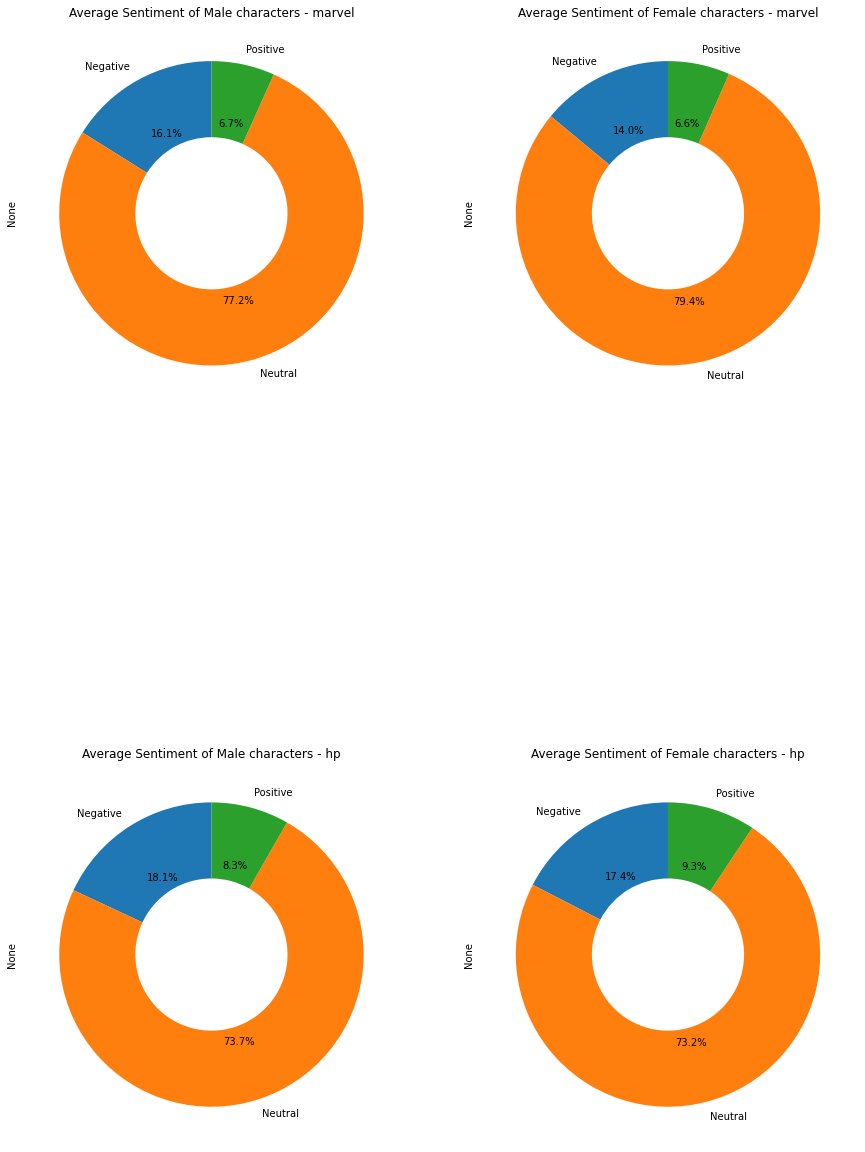

In [ ]:
def plot_emotions_movies(character_sentiments, movies):
  """
  This functions plots the emotions of male and female characters for the list of
  movies given

    Parameters:
      character_sentiments: dict: having the name of the character and sentiments
      movies: list: The list of movies whose characters we have to plot

    Returns:
      Nothing
  """
  fig, axs = plt.subplots(len(movies), 2)
  i = 0
  for movie in movies:
    ch = character_sentiments[movie]
    
    df1 = pd.DataFrame(ch).transpose().fillna(0)
    df1['gender'] = df1.index
    df1['gender'] = df1.gender.apply(lambda x: genders[movie].get(x, '' ))

    df2 = df1[df1.gender == 'male']
    df2.drop('gender', axis=1, inplace=True)

    df3 = df1[df1.gender == 'female']
    df3.drop('gender', axis=1, inplace=True)

    df2.div(df2.sum(axis=1), axis=0).reset_index().fillna(0).mean().plot.pie(y=df.index,
              shadow=False,
              ax=axs[i, 0], 
              wedgeprops={'width':0.5},
              startangle=90,
              title='Average Sentiment of Male characters - ' + movie,
              autopct='%1.1f%%',
              figsize=(15, 25))

    df3.div(df3.sum(axis=1), axis=0).reset_index().fillna(0).mean().plot.pie(y=df.index,
              shadow=False,
              ax=axs[i, 1],
              wedgeprops={'width':0.5},
              startangle=90,
              title='Average Sentiment of Female characters - ' + movie,
              autopct='%1.1f%%')  
    i+=1
  plt.savefig('a.jpg')

plot_emotions_movies(character_sentiments, movies)

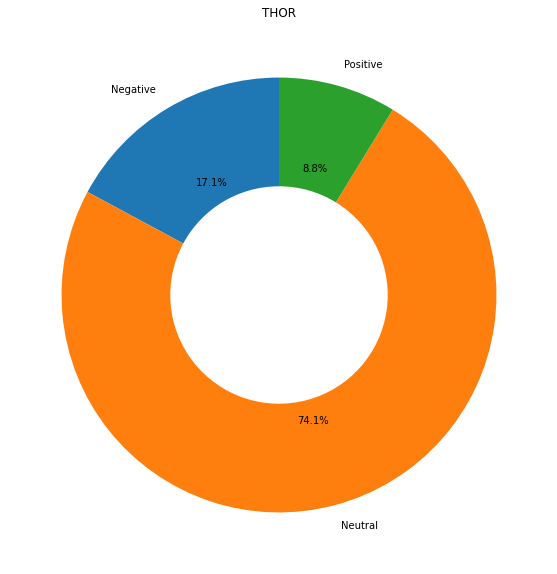

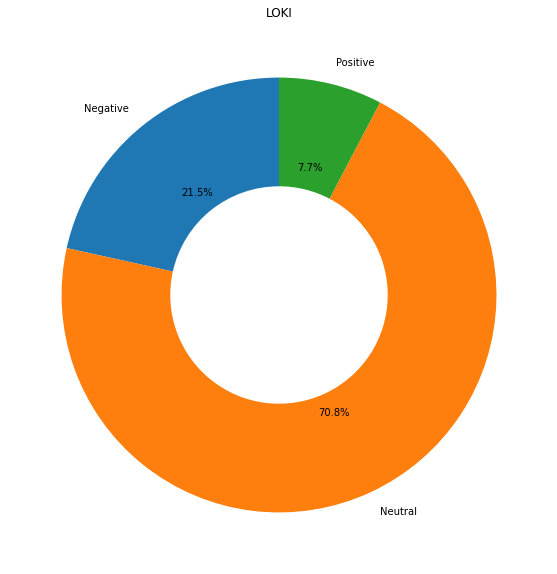

In [ ]:
def plot_character(character_name, movie_name, character_sentiments):
  """
  This functions takes the name of the character, and plot their sentiment in a ring chart
  
    Parameters:
      character_name: str: The name of the character who emotions are to be displayed\
      movie_name: str: the movie which the character belongs to
      character_sentiments: dict: having the name of the character and sentiments
    Returns:
      Nothing
  """
  if not character_sentiments.get(movie_name, {}).get(character_name):
    print("The character does not exist")
    return
  plt.figure(figsize=(10,10))
  plt.pie(character_sentiments[movie_name][character_name].values(), 
          labels=character_sentiments[movie_name][character_name].keys(),
          # ax=axs[i, 1],
          wedgeprops={'width':0.5},
          startangle=90,
          autopct='%1.1f%%')
  plt.title(character_name)

plot_character('THOR', 'marvel', character_sentiments)
plot_character('LOKI', 'marvel', character_sentiments)


## Evaluation

In [ ]:
"""
We are running stanza on Harry's dialogues.
Then we will save the file
"""

harry = pd.read_csv('harry.csv')
emotions = ['Negative', 'Neutral', 'Positive']
nlp = stanza.Pipeline(lang='en', processors='tokenize,sentiment')
doc = nlp(". ".join(harry.text))
sentiment = [i.sentiment for i in doc.sentences]
text = [i.text for i in doc.sentences]

text = [i.text for i in doc.sentences]
harry_stanza = pd.DataFrame({'text':text,'sentiment':sentiment})
harry_stanza.to_csv('harry_stanza.csv', index=False)

In [ ]:
"""
Here we are reading the file again after manually annotating it as well
"""
harry_annotated = pd.read_csv('harry_stanza_annotated.csv')
print(accuracy_score(harry_annotated['person 1'], harry_annotated['person 2']))
print(accuracy_score(harry_annotated['sentiment'], harry_annotated['person 1']))
print(accuracy_score(harry_annotated['sentiment'], harry_annotated['person 2']))

# Emotions Analysis

## NCRLEX

Plutchik's Wheel of Emotions is used on top of NRCLEX

In [ ]:
def func(x):
  """
  A functıon to apply NRCLEX on a dıalogue. It also computes new emotıons ıncludıng,
  anxıety, prıde, envy, domınance, and curıosıty. Thıs ıs a functıon that ıs only
  used to apply on a serıes on dıalogue

    Parameters:
      x: str: A strıng, preferably dıalogue, on whıch we have to run NRCLEX
    
    Returns:
      res: dıct: wıth emotıons, havıng 1 ıf the emotıon ıs present, 0 otherwıse
  """
  xx = 'NA'
  res = NRCLex(x).affect_frequencies
  del res['negative']
  del res['positive']
  total = sum(res.values())
  if total != 0:
    for keys in res.keys():
      res[keys] = res[keys]/total
  if res.get('anticipation') and res.get('trust'):
    res['hope'] = res['anticipation']*res['trust']
  
  if res.get('joy') and res.get('fear'):
    res['guilt'] = res['joy']*res['fear']
  
  if res.get('trust') and res.get('surprise'):
    res['curiosity'] = res['trust']*res['surprise']

  if res.get('fear') and res.get('sadness'):
    res['despair'] = res['fear']*res['sadness']

  if res.get('surprise') and res.get('disgust'):
    res['unbelief'] = res['surprise']*res['disgust']

  if res.get('sadness') and res.get('anger'):
    res['envy'] = res['sadness']*res['anger']

  if res.get('disgust') and res.get('anticipation'):
    res['cynicism'] = res['disgust']*res['anticipation']

  if res.get('anger') and res.get('joy'):
    res['pride'] = res['anger']*res['joy']

  if res.get('anticipation') and res.get('joy'):
    res['optimism'] = res['anticipation']*res['joy']

  if res.get('joy') and res.get('trust'):
    res['love'] = res['joy']*res['trust']

  if res.get('trust') and res.get('fear'):
    res['submission'] = res['trust']*res['fear']

  if res.get('fear') and res.get('surprise'):
    res['awe'] = res['fear']*res['surprise']

  if res.get('surprise') and res.get('sadness'):
    res['disapproval'] = res['surprise']*res['sadness']

  if res.get('sadness') and res.get('disgust'):
    res['remorse'] = res['sadness']*res['disgust']

  if res.get('disgust') and res.get('anger'):
    res['contempt'] = res['disgust']*res['anger']

  if res.get('anger') and res.get('anticipation'):
    res['aggressiveness'] = res['anger']*res['anticipation']

  if res.get('anticipation') and res.get('fear'):
    res['anxiety'] = res['anticipation']*res['fear']

  if res.get('joy') and res.get('surprise'):
    res['delight'] = res['joy']*res['surprise']

  if res.get('trust') and res.get('sadness'):
    res['sentimentality'] = res['trust']*res['sadness']

  if res.get('fear') and res.get('disgust'):
    res['shame'] = res['fear']*res['disgust']
  
  if res.get('surprise') and res.get('anger'):
    res['outrage'] = res['surprise']*res['anger']

  if res.get('sadness') and res.get('anticipation'):
    res['pessimism'] = res['sadness']*res['anticipation']

  if res.get('disgust') and res.get('joy'):
    res['morbidness'] = res['disgust']*res['joy']

  if res.get('anger') and res.get('trust'):
    res['dominance'] = res['anger']*res['trust']
  
  if res.get('submission') and res.get('love'):
    res['confined'] = res['submission']*res['love']

  if not res.get('disapproval') and not res.get('outrage') and not res.get('aggressiveness') and not res.get('pride'):
    res['polite'] = 1
  
  # for key in res.keys():
  #   if res[key] > 0:
  #     res[key] = 1 

  return res

"""
Main script that reads the databases, run stanza on them, and save the final dataframe
"""
# movies = ['marvel', 'hp', 'PP', 'horror']  # A list of movies data bases we are going to work with
# data_frames = {}
# character_sentiments = {}
# genders = {}  # A dict of dict

# # Reading the files for all the movies
# for movie in movies:
#   data_frames[movie] = pd.read_csv(movie+'_db.csv').drop('Unnamed: 0', axis=1)
#   df = pd.concat([df, data_frames[movie]], ignore_index=True)

# df['emotions'] = df['text'].apply(func)

'\nMain script that reads the databases, run stanza on them, and save the final dataframe\n'

In [ ]:
df = pd.read_csv('final_merged_db_last.csv',delimiter=';')
df = df[['character', 'text', 'gender']]
df['emotions'] = df['text'].apply(func)
df

,character,text,gender,emotions
0,A.J.,What did our always-at-lunch-Swedish geologis...,male,"{'fear': 0.0, 'anger': 0.0, 'anticip': 0.0, 't..."
1,A.J.,What's his mood?,male,"{'fear': 0.0, 'anger': 0.0, 'anticip': 0.0, 't..."
2,A.J.,"I'm on top of it Harry, you have a second?",male,"{'fear': 0.0, 'anger': 0.0, 'anticip': 0.0, 't..."
3,A.J.,I'll hurry. I've worked for you for a long time.,male,"{'fear': 0.0, 'anger': 0.0, 'anticip': 0.0, 't..."
4,A.J.,And you've been real good to me,male,"{'fear': 0.0, 'anger': 0.0, 'anticip': 0.0, 't..."
...,...,...,...,...
27632,YULE MAY,I want to get my purse! I want to get my pur...,female,"{'fear': 0.0, 'anger': 0.0, 'anticip': 0.0, 't..."
27633,YULE MAY,Aibee! I want my purse! I want my purse! J...,female,"{'fear': 0.0, 'anger': 0.0, 'anticip': 0.0, 't..."
27634,YULE MAY,"""'What you done put up in this?'. She said, '...",female,"{'fear': 0.0, 'anger': 0.5, 'anticip': 0.0, 't..."
27635,ZALUCHI,I also don't believe in drugs. For years I pa...,male,"{'fear': 0.0, 'anger': 0.0, 'anticip': 0.0, 't..."


### Creating DataBase

In [ ]:
df = pd.concat([df.drop(['emotions'], axis = 1), df['emotions'].apply(pd.Series)], axis = 1).fillna(0)
df

,character,text,gender,fear,anger,anticip,trust,surprise,sadness,disgust,...,anxiety,confined,disapproval,unbelief,remorse,shame,aggressiveness,dominance,pride,outrage
0,A.J.,What did our always-at-lunch-Swedish geologis...,male,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
1,A.J.,What's his mood?,male,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
2,A.J.,"I'm on top of it Harry, you have a second?",male,0.000000,0.000000,0.0,0.500000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
3,A.J.,I'll hurry. I've worked for you for a long time.,male,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
4,A.J.,And you've been real good to me,male,0.000000,0.000000,0.0,0.400000,0.200000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27632,YULE MAY,I want to get my purse! I want to get my pur...,female,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
27633,YULE MAY,Aibee! I want my purse! I want my purse! J...,female,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
27634,YULE MAY,"""'What you done put up in this?'. She said, '...",female,0.000000,0.500000,0.0,0.000000,0.000000,0.000000,0.500000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
27635,ZALUCHI,I also don't believe in drugs. For years I pa...,male,0.000000,0.000000,0.0,0.500000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000


In [ ]:
df2.to_csv('final_db_april_22.csv')

## Visualizations

### Pie Charts

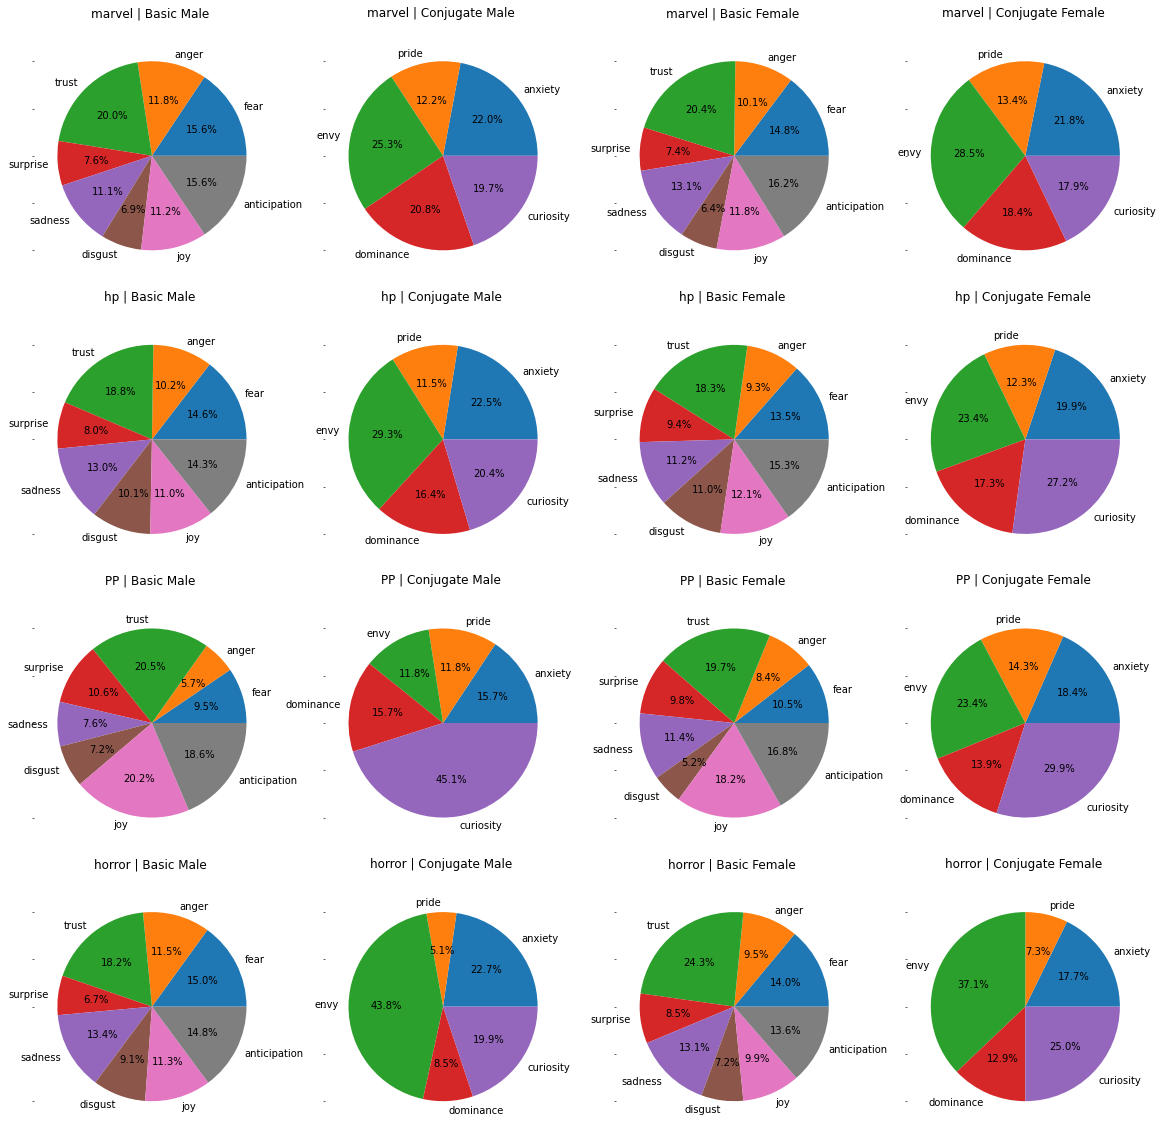

In [ ]:
"""
Code to plot some of the emotıons for our report and the presentatıon
"""
basic_emotions = ['fear', 'anger', 'trust', 'surprise', 'sadness', 'disgust', 'joy', 'anticipation']
derived_emotions = ['anxiety', 'pride', 'envy', 'dominance', 'curiosity']
fig, axs = plt.subplots(len(movies), 4, sharey=True)

i = 0
for movie in movies:
  df = data_frames[movie]
  df2 = pd.concat([df.drop(['emotions'], axis = 1), df['emotions'].apply(pd.Series)], axis = 1).fillna(0)

  df2[(df2.types=='male')][basic_emotions].sum(axis=0).plot(
      labels=basic_emotions, 
      label="",
      ax=axs[i, 0],
      kind='pie', 
      autopct='%1.1f%%',
      figsize=(20,20)
      )
  axs[i,0].set_title("%s | Basic Male \n" % movie, fontsize=12)
  
  df2[(df2.types=='male')][derived_emotions].sum(axis=0).plot(
      labels=derived_emotions, 
      label="",
      ax=axs[i, 1],
      kind='pie', 
      autopct='%1.1f%%',
      figsize=(20,20)
      )
  axs[i,1].set_title("%s | Conjugate Male \n" % movie, fontsize=12)
  
  df2[(df2.types=='female')][basic_emotions].sum(axis=0).plot(
      labels=basic_emotions, 
      label="",
      ax=axs[i, 2],
      kind='pie', 
      autopct='%1.1f%%',
      figsize=(20,20)
      )
  axs[i,2].set_title("%s | Basic Female \n" % movie, fontsize=12)
  
  df2[(df2.types=='female')][derived_emotions].sum(axis=0).plot(
      labels=derived_emotions, 
      label="",
      ax=axs[i, 3],
      kind='pie', 
      autopct='%1.1f%%',
      figsize=(20,20)
      )
  axs[i,3].set_title("%s | Conjugate Female \n" % movie, fontsize=12)
  
  i += 1
  plt.savefig('b.jpg')

# ['marvel', 'hp', 'PP', 'horror'] 

### Bar Charts

In [ ]:
"""
Code to plot some of the emotıons for our report and the presentatıon
"""
basic_emotions = ['fear', 'anger', 'trust', 'surprise', 'sadness', 'disgust', 'joy', 'anticipation']
derived_emotions = ['hope', 'guilt', 'curiosity', 'despair', 'unbelief',\
                    'envy', 'cynicism', 'pride', 'optimism', 'love',\
                    'submission', 'awe', 'disapproval', 'remorse', 'contempt',\
                    'aggressiveness', 'anxiety', 'delight', 'sentimentality', 'shame',\
                    'outrage', 'pessimism', 'morbidness', 'dominance', 'confined']
f = plt.figure(figsize=(20,30))
# advanced_emotions = ['confined']
# fig, axs = f.subplots(4, sharey=True)


# i = 0
# for movie in movies:
#   df = data_frames[movie]

df2 = pd.concat([df.drop(['emotions'], axis = 1), df['emotions'].apply(pd.Series)], axis = 1).fillna(0)
number = 411+0
ax = f.add_subplot(number)
X = df2[(df2.gender=='male')][derived_emotions].sum(axis=0)
X = (X / X.sum()) * 100
X1 = df2[(df2.gender=='female')][derived_emotions].sum(axis=0)
X1 = (X1 / X1.sum()) * 100
X_axis = np.arange(len(derived_emotions))
ax.bar(X_axis - 0.2, X, 0.4, label = 'Boys')
ax.bar(X_axis + 0.2, X1, 0.4, label = 'Girls')
ax.set_xticks(np.arange(len(derived_emotions)))
ax.set_xticklabels(derived_emotions, rotation=90)
ax.set_xlabel("Emotions")
# ax.set_title(movie)
ax.legend()

# i += 1
plt.savefig('b.jpg')


### Others

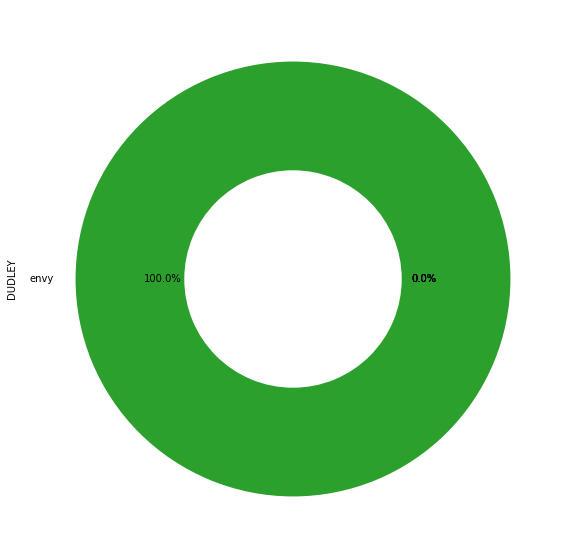

In [ ]:
"""
Code to plot emotıons of 1 character. Maınly for presentatıon and the report
"""
movie = 'hp'
character = 'DUDLEY'

df = data_frames[movie]
df2 = pd.concat([df.drop(['emotions'], axis = 1), df['emotions'].apply(pd.Series)], axis = 1).fillna(0)

df2[(df2.character==character)][derived_emotions].sum(axis=0).plot(
    labels=derived_emotions, 
    label=character,
    kind='pie', 
    wedgeprops={'width':0.5},
    autopct='%1.1f%%',
    figsize=(10,10)
    )

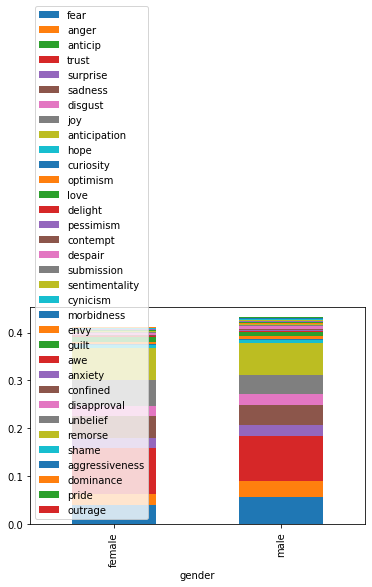

In [ ]:
mean_emotions = df2.groupby('gender').median()
mean_emotions.plot.bar(stacked=True);

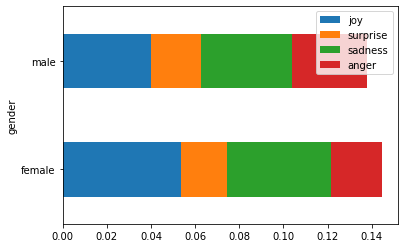

In [ ]:
mean_emotions[['joy','surprise','sadness','anger']].plot.barh(stacked=False);

In [ ]:
mean_emotions['envy'] =  mean_emotions['envy'] /2

In [ ]:
mean_emotions[['envy','dominance','outrage','pride']] = mean_emotions[['envy','dominance','outrage','pride']] * 100

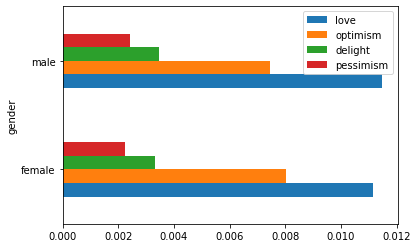

In [ ]:
mean_emotions[['love','optimism','delight','pessimism']].plot.barh(stacked=False);

In [ ]:
mean_emotions

,fear,anger,anticip,trust,surprise,sadness,disgust,joy,anticipation,hope,curiosity,optimism,love,delight,pessimism,contempt,despair,submission,sentimentality,cynicism,morbidness,envy,guilt,awe,anxiety,confined,disapproval,unbelief,remorse,shame,aggressiveness,dominance,pride,outrage
gender,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
female,0.043356,0.027328,0.0,0.095998,0.025794,0.054358,0.029610,0.062376,0.071451,0.007412,0.003520,0.008010,0.011163,0.003309,0.002226,0.00343,0.006449,0.002865,0.002681,0.000777,0.000707,0.003522,0.001191,0.001447,0.003133,0.000040,0.002612,0.000602,0.002964,0.002735,0.001001,0.001192,0.000823,0.000743
male,0.062182,0.040154,0.0,0.098985,0.029906,0.048940,0.035463,0.050220,0.071604,0.008197,0.003447,0.007463,0.011461,0.003456,0.002426,0.00401,0.008786,0.003714,0.002800,0.000985,0.000644,0.004376,0.001880,0.001576,0.003274,0.000061,0.001913,0.000727,0.003557,0.003802,0.001828,0.002057,0.000959,0.001488


# Clustering the vectors

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN  # Imported K means for self testing

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors

from itertools import islice, cycle
import plotly.express as px
from mpl_toolkits.mplot3d import Axes3D
import warnings
warnings.filterwarnings('ignore')


from matplotlib import rcParams
rcParams['figure.figsize'] = 14,7

## Data Pre Processing

In [ ]:
df = pd.read_csv('final_merged_db_last.csv',delimiter=';')
df

,character,text,number,gender,movie_name,fear,anger,anticip,trust,surprise,...,aggressiveness,delight,sentimentality,outrage,pessimism,morbidness,awe,anxiety,guilt,confined
0,A.J.,What did our always-at-lunch-Swedish geologis...,0,male,armageddon,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,A.J.,What's his mood?,0,male,armageddon,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,A.J.,"I'm on top of it Harry, you have a second?",0,male,armageddon,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,A.J.,I'll hurry. I've worked for you for a long time.,0,male,armageddon,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,A.J.,And you've been real good to me,0,male,armageddon,0,0,0,1,1,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27632,YULE MAY,I want to get my purse! I want to get my pur...,0,female,the-help-2018,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27633,YULE MAY,Aibee! I want my purse! I want my purse! J...,0,female,the-help-2018,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27634,YULE MAY,"""'What you done put up in this?'. She said, '...",0,female,the-help-2018,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27635,ZALUCHI,I also don't believe in drugs. For years I pa...,0,male,the-godfather-1972,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
movie_names = df['movie_name'].unique()
movie_names

array(['armageddon', 'HP', 'marvel', 'the-help-2018',
       'the-imitation-game', 'TLOTR-2', 'la-la-land',
       'the-dark-knight-2008', 'the-dark-knight-rises-2012',
       'beauty-and-the-beast', 'little-women', 'call-me-by-your-name',
       'devil-wears-prada', 'the-shawshank-redemption-1994',
       'notting-hill-1999', 'the-godfather-1972', 'TLOTR-1', 'TLOTR-3',
       'dune', 'pride-and-prejudice', 'pulp-fiction-1994', 'jaws-1975',
       'gladiator'], dtype=object)

### Data Statistics

In [ ]:
pd.set_option("display.max_columns", 45)
df.describe()

,character,text,gender,emotions
count,26279,26279,26279,26279
unique,455,25024,2,1845
top,HARRY,What?,male,"{'fear': 0.0, 'anger': 0.0, 'anticip': 0.0, 't..."
freq,1995,65,19395,15061


Some emotions like Politeness are present in most sentences and some emotions like confined or morbid are rarely present. The data is mostly on the same scale and thus doesn't need to be further standardized or normalized.

The main reason for this could be the subjectiveness we have added while creating politeness emotion, therefore we're going to drop it

In [ ]:
df2 = df2.drop('polite', axis=1)

NameError: ignored

### Null Values

In [ ]:
print("Are there any null values in the our data? %s" % df.isna().any().any())

Are there any null values in the our data? False


### Duplicated Values

In [ ]:
print("Are there any duplicated values in the data? %s" % df.duplicated().any())

Are there any duplicated values in the data? True


In [ ]:
df[df.duplicated(keep=False)]

,character,text,gender,fear,anger,anticip,trust,surprise,sadness,disgust,...,anxiety,confined,disapproval,unbelief,remorse,shame,aggressiveness,dominance,pride,outrage
25,A.J.,"I love you, Grace.",male,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31,A.J.,"I love you, Grace.",male,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
148,AIBILEEN,"Yes, ma'am.",female,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
160,AIBILEEN,"Yes, ma'am.",female,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
161,AIBILEEN,"No, ma'am.",female,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27357,WILLIAM,Okay.,male,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27366,WILLIAM,Hello.,male,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27389,WILLIAM,What?,male,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27624,YULE MAY,"Yes, ma'am.",female,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The duplicated Values must be removed from the database

In [ ]:
df = df.drop_duplicates(keep='last').reset_index(drop=True)
df.sample(5)

,character,text,gender,fear,anger,anticip,trust,surprise,sadness,disgust,...,anxiety,confined,disapproval,unbelief,remorse,shame,aggressiveness,dominance,pride,outrage
25471,WAYNE,Someone else will work out what Dr. Pavel did...,male,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
717,ALFRED,Wrong?,male,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
227,AIBILEEN,We ain't doing civil rights. We just tellin'...,female,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16740,MICHAEL,Uhh... You and I are gonna moo...move my fath...,male,0.0,0.0,0.0,0.5,0.0,0.5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12055,HOOPER,Yeah. Like the kid on your beach. I wish I co...,male,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
x = df2[['character','gender']]
y = df2.drop(['character','gender'], axis=1)

NameError: ignored

In [ ]:
x

,character,gender,movie_name
0,A.J.,male,armageddon
1,ABERFORTH,male,HP
2,AGENT COULSON,male,marvel
3,AIBILEEN,female,the-help-2018
4,ALAN TURING,male,the-imitation-game
...,...,...,...
508,ÉOMER,male,TLOTR-2
509,ÉOMER,male,TLOTR-3
510,ÉOTHAIN,male,TLOTR-2
511,ÉOWYN,female,TLOTR-2


In [ ]:
y

In [ ]:
normalized_df=(abs(y-y.mean()))/y.std()
normalized_df

,fear,anger,trust,surprise,sadness,disgust,joy,anticipation,hope,curiosity,optimism,love,delight,pessimism,contempt,despair,submission,sentimentality,cynicism,morbidness,envy,guilt,awe,anxiety,confined,disapproval,unbelief,remorse,shame,aggressiveness,dominance,pride,outrage
0,0.712521,0.328144,0.265404,0.218153,0.269414,0.403279,0.498621,0.204127,0.015053,0.326670,0.001189,0.300471,0.279022,0.462120,0.095028,0.268964,0.183191,0.165749,0.089812,0.265307,0.387416,0.032053,0.122343,0.121202,0.153796,0.236735,0.234639,0.520080,0.575953,0.610631,0.562601,0.594124,0.240635
1,0.026563,1.735678,0.284943,0.641093,0.492839,0.851389,0.585323,0.591697,0.931189,0.639071,0.324908,0.225917,0.602105,0.199385,2.129903,0.283455,0.141797,0.143404,2.757627,0.379158,0.094916,0.087669,0.546370,0.728379,0.262817,0.318115,0.391692,0.035273,1.250498,0.328472,2.269891,0.594124,0.240635
2,0.464077,0.718999,0.220009,0.554463,0.337433,0.538818,0.710249,0.862941,0.348611,0.012475,0.645136,0.390505,0.264215,0.478814,0.514040,0.288950,0.937945,0.568832,0.533709,0.379158,0.461296,0.355541,0.726060,0.357222,0.476327,0.703833,0.152370,0.408679,0.462030,0.610631,0.137862,0.013373,0.031346
3,0.281279,0.086753,0.197022,0.056979,0.247228,0.116983,0.618318,0.297960,0.735116,0.122106,0.444579,0.408896,0.221101,0.156657,0.534277,0.231099,0.354878,0.250532,0.019247,0.074606,0.120683,0.014506,0.034696,0.033901,0.082310,0.156659,0.603733,0.115179,0.476213,0.076074,0.314684,0.031531,0.020509
4,0.062059,0.273016,0.597731,0.098243,0.013470,0.475925,0.406029,0.117676,0.096899,0.024301,0.358580,0.135867,0.267718,0.068493,0.268442,0.019542,0.002824,0.035376,0.223640,0.324226,0.205234,0.082925,0.503190,0.162345,0.437437,0.494319,0.284279,0.339388,0.471714,0.022762,0.229716,0.132143,0.073720
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
508,0.288942,0.363395,0.980796,0.240093,0.258505,0.568883,0.487207,0.070069,0.885256,0.025287,0.798108,0.948421,0.170483,0.632857,0.595181,0.056599,1.243458,0.143244,0.533709,0.239332,0.271915,0.604000,0.541540,0.535229,1.215206,0.050956,0.114832,0.485593,0.459187,0.103087,1.888643,2.542386,0.315815
509,0.585419,0.299143,1.080057,0.641093,0.205134,0.150191,3.245579,0.605259,1.324517,0.639071,0.958874,2.579022,0.602105,0.476833,0.208769,0.953983,2.851089,2.335477,2.324125,0.379158,0.104146,0.375447,0.546370,2.291520,0.370252,0.318115,0.391692,0.276482,0.238645,1.240837,0.562601,0.594124,0.240635
510,1.122140,0.915615,1.180635,0.641093,0.777198,0.627647,0.897442,1.198530,0.802340,0.639071,0.735947,0.665462,0.602105,0.478814,0.679254,0.732484,0.725659,0.586281,0.533709,0.379158,0.590540,0.355541,0.546370,0.618156,0.476327,0.318115,0.391692,0.565288,0.622185,0.610631,0.562601,0.594124,0.240635
511,0.429351,0.765048,0.257200,0.291748,0.125231,0.541803,0.261703,0.813923,0.704132,0.057408,0.049313,0.254693,0.466568,0.223948,0.016173,0.418356,0.510765,1.991015,0.287176,0.118903,0.086096,0.260540,0.224486,0.310644,0.462365,0.215094,0.274845,0.270544,0.220198,0.030739,0.222427,1.723216,0.008642


In [ ]:
df2.to_csv('final.csv', index=False)

## Visualization

In [ ]:
def visualize_clusters(data, dimension):
  """
  This function takes data and plots it into two or three dimensions
  """
  temp = data.select_dtypes(['number']).copy()# Taking the vector only
  temp = temp.drop('number', axis=1)
  tsne = TSNE(n_components=dimension, verbose=1, perplexity=40, n_iter=300)
  temp = tsne.fit_transform(temp)

  temp = pd.DataFrame(temp)
  temp['gender'] = data['gender']
  
  if dimension == 2:
    temp.columns =['x0', 'x1', 'gender']
    sns.lmplot(data=temp, x='x0', y='x1', hue='gender', fit_reg=False, size=8,\
                   palette="Set1")
  if dimension == 3:
    temp.columns =['x0', 'x1', 'x2', 'gender']
    fig = px.scatter_3d(temp, x='x0', y='x1', z='x2',
              color='gender')
    fig.show()

### By Dialogue

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 26279 samples in 0.001s...
[t-SNE] Computed neighbors for 26279 samples in 18.410s...
[t-SNE] Computed conditional probabilities for sample 1000 / 26279
[t-SNE] Computed conditional probabilities for sample 2000 / 26279
[t-SNE] Computed conditional probabilities for sample 3000 / 26279
[t-SNE] Computed conditional probabilities for sample 4000 / 26279
[t-SNE] Computed conditional probabilities for sample 5000 / 26279
[t-SNE] Computed conditional probabilities for sample 6000 / 26279
[t-SNE] Computed conditional probabilities for sample 7000 / 26279
[t-SNE] Computed conditional probabilities for sample 8000 / 26279
[t-SNE] Computed conditional probabilities for sample 9000 / 26279
[t-SNE] Computed conditional probabilities for sample 10000 / 26279
[t-SNE] Computed conditional probabilities for sample 11000 / 26279
[t-SNE] Computed conditional probabilities for sample 12000 / 26279
[t-SNE] Computed conditional probabilities for s

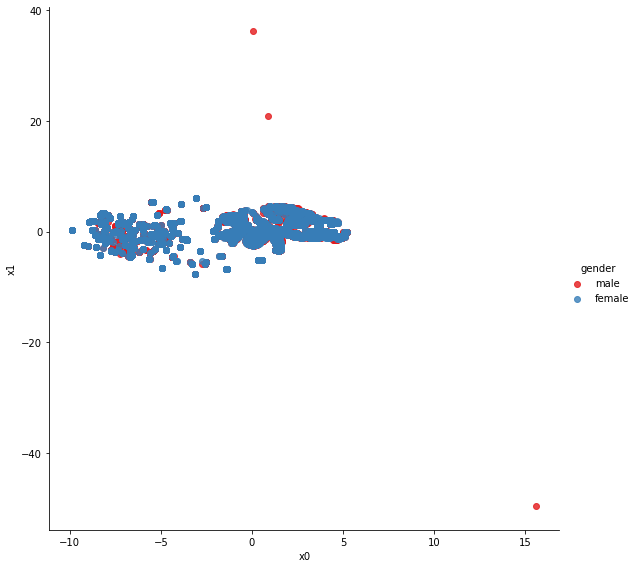

In [ ]:
visualize_clusters(df, 2)

In [ ]:
visualize_clusters(df, 3)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 26279 samples in 0.001s...
[t-SNE] Computed neighbors for 26279 samples in 15.154s...
[t-SNE] Computed conditional probabilities for sample 1000 / 26279
[t-SNE] Computed conditional probabilities for sample 2000 / 26279
[t-SNE] Computed conditional probabilities for sample 3000 / 26279
[t-SNE] Computed conditional probabilities for sample 4000 / 26279
[t-SNE] Computed conditional probabilities for sample 5000 / 26279
[t-SNE] Computed conditional probabilities for sample 6000 / 26279
[t-SNE] Computed conditional probabilities for sample 7000 / 26279
[t-SNE] Computed conditional probabilities for sample 8000 / 26279
[t-SNE] Computed conditional probabilities for sample 9000 / 26279
[t-SNE] Computed conditional probabilities for sample 10000 / 26279
[t-SNE] Computed conditional probabilities for sample 11000 / 26279
[t-SNE] Computed conditional probabilities for sample 12000 / 26279
[t-SNE] Computed conditional probabilities for s

### By characters

In [ ]:
df2 = df.groupby(["character", "gender"]).mean()
# df2 = df2.drop('number', axis=1)
# df2 = df2.droplevel(1)
df2 = df2.reset_index()

In [ ]:
df2

,character,gender,fear,anger,anticip,trust,surprise,sadness,disgust,joy,...,anxiety,confined,disapproval,unbelief,remorse,shame,aggressiveness,dominance,pride,outrage
0,A.J.,male,0.020990,0.050439,0.0,0.075909,0.019549,0.034461,0.011748,0.084242,...,0.002633,0.000037,0.000537,0.000269,0.000269,0.000269,0.000000,0.000000,0.000000,0.000000
1,ABERFORTH,male,0.056140,0.107519,0.0,0.121554,0.000000,0.019298,0.077444,0.089474,...,0.007135,0.000084,0.000000,0.000000,0.003567,0.010877,0.002536,0.009495,0.000000,0.000000
2,AGENT COULSON,male,0.033721,0.007973,0.0,0.116168,0.055260,0.029845,0.004651,0.011296,...,0.005168,0.000000,0.006744,0.000930,0.000930,0.000930,0.000000,0.001424,0.000949,0.001405
3,AIBILEEN,female,0.043088,0.040649,0.0,0.081580,0.026999,0.035967,0.026739,0.091465,...,0.003455,0.000064,0.001066,0.001702,0.004042,0.000848,0.001854,0.000831,0.000879,0.001137
4,ALAN TURING,male,0.054321,0.026060,0.0,0.147496,0.034173,0.051831,0.007944,0.029653,...,0.002415,0.000104,0.005362,0.000184,0.001342,0.000874,0.001711,0.001116,0.000722,0.000862
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
452,YULE MAY,female,0.013889,0.052778,0.0,0.066667,0.011111,0.013889,0.041667,0.066667,...,0.000000,0.000000,0.000000,0.000000,0.003472,0.003472,0.002222,0.002222,0.002222,0.002222
453,ZALUCHI,male,0.071429,0.071429,0.0,0.321429,0.071429,0.142857,0.071429,0.250000,...,0.000000,0.000000,0.020408,0.010204,0.020408,0.010204,0.000000,0.010204,0.000000,0.010204
454,ÉOMER,male,0.075991,0.045355,0.0,0.181263,0.014042,0.042829,0.008392,0.123904,...,0.008367,0.000169,0.001336,0.000359,0.001571,0.001929,0.002672,0.006225,0.003713,0.002177
455,ÉOTHAIN,male,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


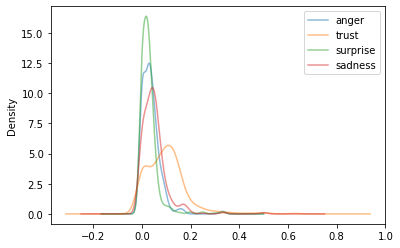

In [ ]:
df2[['anger','trust','surprise','sadness']].plot(kind="density",alpha=0.5)

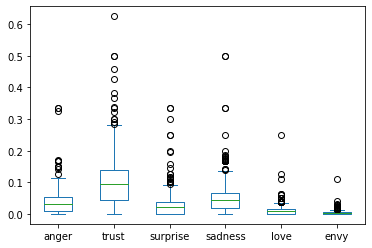

In [ ]:
df2[['anger','trust','surprise','sadness','love','envy']].plot(kind="box")

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 457 samples in 0.000s...
[t-SNE] Computed neighbors for 457 samples in 0.025s...
[t-SNE] Computed conditional probabilities for sample 457 / 457
[t-SNE] Mean sigma: 0.119982
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.779587
[t-SNE] KL divergence after 300 iterations: 0.675674


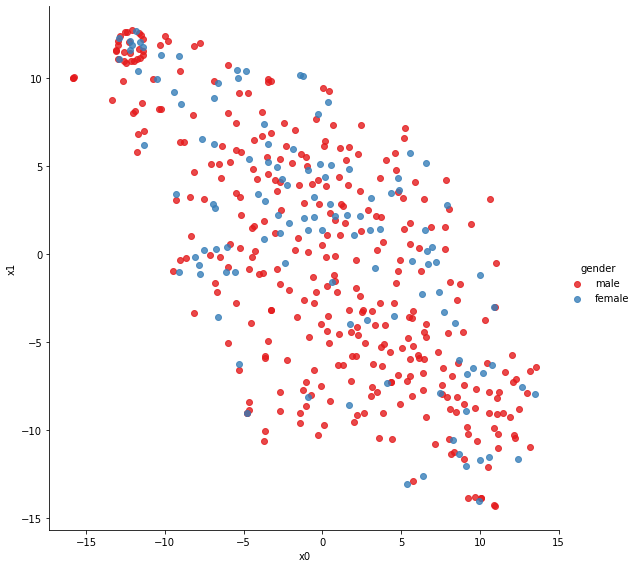

In [ ]:
visualize_clusters(df2, 2)

In [ ]:
visualize_clusters(df2, 3)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 457 samples in 0.001s...
[t-SNE] Computed neighbors for 457 samples in 0.022s...
[t-SNE] Computed conditional probabilities for sample 457 / 457
[t-SNE] Mean sigma: 0.119982
[t-SNE] KL divergence after 250 iterations with early exaggeration: 111.603271
[t-SNE] KL divergence after 300 iterations: 3.167349


## Kmeans

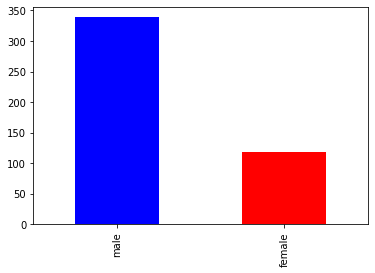

In [ ]:
# 339 male and 118 female characters
df2.gender.value_counts().plot(kind='bar',color=['b','r'])

### Elbow Method

In [ ]:
Sum_of_squared_distances = []
K = range(1,50)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(df2.select_dtypes(['number']).drop('number', axis=1))
    Sum_of_squared_distances.append(km.inertia_)

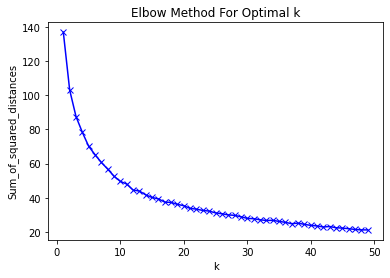

In [ ]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

### clustering distribution in every cluster

In [ ]:
kmeans = KMeans(n_clusters=7, random_state=42).fit(df2.select_dtypes(['number']).drop('number', axis=1))

In [ ]:
# Assigning the label
temp = df2.copy()
temp['types_predicted'] =  kmeans.labels_

In [ ]:
for i in range(0, 7):
  print(temp[temp.types_predicted == i].gender.value_counts(), end='\n---------------------\n')

male      73
female    30
Name: gender, dtype: int64
---------------------
male      75
female    23
Name: gender, dtype: int64
---------------------
male      135
female     53
Name: gender, dtype: int64
---------------------
male      26
female     6
Name: gender, dtype: int64
---------------------
male      6
female    1
Name: gender, dtype: int64
---------------------
male    1
Name: gender, dtype: int64
---------------------
male      23
female     5
Name: gender, dtype: int64
---------------------


No interesting pattern was found, mainly they are being clustered as one using k means, so we should try Hiererchical or DBSCAN

## Hiererchical Clustering

In [ ]:
from sklearn.cluster import AgglomerativeClustering

In [ ]:
Agg_hc = AgglomerativeClustering(n_clusters = 7, affinity = 'euclidean', linkage = 'ward')
y_hc = Agg_hc.fit_predict(df2.select_dtypes(['number']))
np.unique(y_hc, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6]), array([ 68,  42,  84,  15,  47,  27, 174]))

In [ ]:
# Assigning the label
temp = df2.copy()
temp['types_predicted_agg'] =  y_hc

In [ ]:
for i in range(0, 7):
  print(temp[temp.types_predicted_agg == i].gender.value_counts(), end='\n---------------------\n')

male      57
female    11
Name: gender, dtype: int64
---------------------
male      32
female    10
Name: gender, dtype: int64
---------------------
male      67
female    17
Name: gender, dtype: int64
---------------------
male      12
female     3
Name: gender, dtype: int64
---------------------
male      37
female    10
Name: gender, dtype: int64
---------------------
male      23
female     4
Name: gender, dtype: int64
---------------------
male      111
female     63
Name: gender, dtype: int64
---------------------


In [ ]:
temp[temp.types_predicted_agg == 6]['character'].unique()

array(['A.J.', 'AIBILEEN', 'ALAN TURING', 'ALEXIS', 'AMY', 'AMY BRANDT',
       'ANCHISE', 'ANDY', 'ANNA', 'ANNELLA', 'ANTHONY', 'APOLLONIA',
       'AUDIENCE MEMBER #2', 'BEAR', 'BELLA', 'BELLE', 'BETH', 'BINGLEY',
       'BOSS', 'BRETT', 'BRODY', 'BRUNO TATTAGLIA', 'BUTCH', 'BUTTONMAN',
       'CADENZA', 'CAROLINE', 'CELIA', 'CHANI', 'CHARLES RICHARDS',
       'CHARLOTTE', 'CHIARA', 'CHICK', 'CHIP', 'CHRISTIAN', 'CICCI',
       'CLOTHILDE', 'CONNIE', 'CUISINIÈR', 'CUSTOMER', 'CUSTOMER #1',
       'DAVID', 'DETECTIVE NOCK', 'DOCTOR', 'DOUG', 'ELIO', 'ELIZABETH',
       'ELLEN', 'EMILY', 'EMPLOYEE', 'ENZO', 'ESMARELDA', 'FABIENNE',
       'FABRIZIO', 'FIANCEE', 'FLIP', 'FLOYD', 'FREDO', 'FRIEDRICH',
       'GAIUS', 'GOLDEN', 'GRACE', 'GREG', 'GURNEY', 'HAGEN', 'HAWAT',
       'HEADMASTER', 'HELEN', 'HENDRICKS', 'HENRY', 'HILLY',
       'HONEY BUNNY', 'HOOPER', 'HUGH ALEXANDER', 'JEAN', 'JEREMY',
       'JESSICA', 'JIMBO', 'JO', 'JOAN CLARKE', 'JOHN', 'JOHN CAIRNCROSS',
       'JOHNNY',

# Classifying Genders

In [ ]:
from sklearn import svm
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV

In [ ]:
df3 = df2[df2.gender!='male organism']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df3.select_dtypes(['number']), df3.gender, test_size=0.30, random_state=42, stratify=df3.gender)

In [ ]:
scaler = StandardScaler().fit(X_train) 
X_scaled_train = scaler.transform(X_train)
X_scaled_test = scaler.transform(X_test)

In [ ]:
parameters = { 
  'gamma' : [0.1,1,10,100],
  'C': [0.1, 1, 10, 100],
  'kernel' : ['linear', 'rbf', 'poly']
}

svc = svm.SVC()
clf = GridSearchCV(svc, parameters )
clf.fit(X_scaled_train, y_train)
sorted(clf.cv_results_.keys())

In [ ]:
svc = svm.SVC(kernel='rbf', gamma=1).fit(X_scaled_train, y_train)   
svc.fit(X_scaled_train, y_train)

In [ ]:
svc.predict(X_scaled_train)

array(['male', 'female', 'male', 'female', 'female', 'male', 'unknown',
       'male', 'male', 'female', 'male', 'male', 'male', 'male', 'female',
       'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male',
       'male', 'male', 'male', 'female', 'female', 'female', 'male',
       'male', 'male', 'male', 'male', 'male', 'male', 'male', 'female',
       'male', 'male', 'female', 'male', 'male', 'male', 'male', 'male',
       'male', 'male', 'male', 'female', 'male', 'male', 'male', 'male',
       'male', 'male', 'female', 'female', 'male', 'male', 'male', 'male',
       'male', 'male', 'male', 'male', 'male', 'female', 'male', 'male',
       'male', 'male', 'male', 'male', 'female', 'male', 'male', 'male',
       'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male',
       'male', 'female', 'male', 'male', 'female', 'female', 'male',
       'male', 'female', 'female', 'female', 'female', 'female', 'female',
       'female', 'male', 'male', 'female', 'male', 'female

In [ ]:
svc.predict(X_scaled_test)

array(['male', 'male', 'male', 'male', 'male', 'male', 'male', 'male',
       'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male',
       'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male',
       'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male',
       'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male',
       'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male',
       'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male',
       'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male',
       'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male',
       'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male',
       'male', 'male', 'male'], dtype=object)

In [ ]:
print("Testing Accuracy: %.2f %%" % (accuracy_score(y_test, svc.predict(X_scaled_test)) * 100))

Testing Accuracy: 64.29 %


In [ ]:
print("Training Accuracy: %.2f %%" % (accuracy_score(y_train, svc.predict(X_scaled_train)) * 100))

Training Accuracy: 95.00 %
